---
# <div align="center"><font color='green'> EEET 2485 | Research Methods for Engineers  </font></div>
## <div align="center"> <font color='green'> **Assessment 3**</font></div>
---

# 1. Introduction

### Dataset
This dataset provides a comprehensive collection of 100 elemental properties for 85 distinct elements, including a wide range of both physical and chemical characteristics. The concept of atomic properties includes essential characteristics such as atomic weight, atomic number, electron configuration, and categorization into groups and periods. Furthermore, the collection offers detailed information on the chemical and physical characteristics of elements, including valence electrons, ionization energy, and electronegativity. The mechanical characteristics are comprehensively represented, including several measurements of hardness (such as Vickers and Brinell), as well as the Young modulus and shear modulus. Significantly, several columns have missing data, with the most substantial gaps detected in parameters such as Vickers hardness and Putz Russo Sicillia electronegativity. This collection is a great resource for education, materials science research, and businesses where knowledge of elemental characteristics is essential.

### Objective
- Understanding the relationship between Zeff, Atomic Radius, and Ionization Energy across all group of different elements.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from tabulate import tabulate
from scipy.stats import f_oneway
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# 2. Load Dataset

In [2]:
df = pd.read_excel("oliynyk-elemental-property-list.xlsx")
print(df)

   Symbol Electron \nconfiguration  Atomic \nweight  Atomic \nnumber  Period  \
0       H                      1s1         1.007940                1       1   
1      He                      1s2         4.002602                2       1   
2      Li                  [He]2s1         6.941000                3       2   
3      Be                  [He]2s2         9.012180                4       2   
4       B               [He]2s22p1        10.811000                5       2   
..    ...                      ...              ...              ...     ...   
80     Tl       [Xe]6s24f145d106p1       204.383300               81       6   
81     Pb       [Xe]6s24f145d106p2       207.200000               82       6   
82     Bi       [Xe]6s24f145d106p3       208.980370               83       6   
83     Th               [Rn]7s26d2       232.038100               90       7   
84      U            [Rn]7s25f36d1       238.028900               92       7   

    Group  quantum \nnumber l  Metal(1)

# 3. Data Processing

### Checking for duplication
First, ensure that each row is unique and corresponds to a distinct chemical element by checking for and removing any duplicate rows.

In [3]:
duplicate = df.duplicated().sum()

if duplicate > 0:
    df = df.drop_duplicates()
    print("Duplicates removed. New dataframe length:", len(df))
else:
    print("No duplicates found.")

No duplicates found.


### Find and Fill in Missing Data
Then, compute and show the quantity of missing data for every column. Only columns containing null values will be shown. This helps in determining whether columns need further processing or data imputation.

In [4]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Filter out columns with no missing values
print(missing_values)

Pauling valence, \nv                7
Pearson\nabsolute (eV)             21
Ghosh\nGupta (eV)                  31
Pauling \nEN                        3
Martynov \nBatsanov EN              5
Mulliken\nEN                        5
Allred\nEN                          5
Putz\nRusso\nSicillia\nEN          33
Gordy\nEN                          28
Pauling, \nR(CN12)                 13
Pauling, \nR(1)                     8
Thermal expansion, \nK^-1          17
Cohesive \nenergy                   2
Bulk modulus,\nGPa                  5
Sheer modulus,\nGPa                24
Young modulus,\nGPa                22
Hardness Vickers,\nGPa             41
Hardness Brinell,\nGPa             21
Resistivity (mΩ)                   10
Electrical Conductivity \n(S/m)    10
Neutron \nMass \nAbsorption         3
Abundance in Earth's \ncrust        2
HHI production                      9
HHI reserve                         9
cost, \npure\n($/100g)              2
dtype: int64


- In order to maintain the accuracy and strength of the analysis, we will use mean imputation to handle any missing values in the dataset. This approach is especially efficient for datasets in which the missing values are considered to be missing entirely at random (MCAR) and the data distribution closely approximates normal.

- Mean imputation is a straightforward approach of dealing with missing data. The process entails substituting all absent (NaN) values in a column with the average value of that column. This strategy is especially beneficial when the data follows a normal distribution, since the mean accurately represents the central tendency.
$$
  \bar{X_i} = \frac{1}{n_i} \sum_{j=1}^{n_i} X_{ij}
  $$

- Effectively handling missing values requires the ability to recognize and differentiate between numeric and non-numeric data types. This distinction is crucial since mean imputation can only be applied on numerical data. Imputing non-numeric data types, such as categorical or ordinal data, requires distinct methods since their central tendency cannot be effectively represented by the mean.

In [5]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

print(df)

   Symbol Electron \nconfiguration  Atomic \nweight  Atomic \nnumber  Period  \
0       H                      1s1         1.007940              1.0     1.0   
1      He                      1s2         4.002602              2.0     1.0   
2      Li                  [He]2s1         6.941000              3.0     2.0   
3      Be                  [He]2s2         9.012180              4.0     2.0   
4       B               [He]2s22p1        10.811000              5.0     2.0   
..    ...                      ...              ...              ...     ...   
80     Tl       [Xe]6s24f145d106p1       204.383300             81.0     6.0   
81     Pb       [Xe]6s24f145d106p2       207.200000             82.0     6.0   
82     Bi       [Xe]6s24f145d106p3       208.980370             83.0     6.0   
83     Th               [Rn]7s26d2       232.038100             90.0     7.0   
84      U            [Rn]7s25f36d1       238.028900             92.0     7.0   

    Group  quantum \nnumber l  Metal(1)

# 4. Analyzing data

### Data Distribution
Analysing data distribution in 4 collumns: 'Atomic radius calculated' 'Zeff', 'Ionization Energy', 'Group' to understand the overall structure and behavior of the data..

In [11]:
columns_of_interest = ['Atomic\nradius calculated', 'Zeff', 'Ionization\nenergy (eV)', 'Group']
df1 = df[columns_of_interest]
df1['Group'] = df1['Group'].astype(int)


C:\Users\Giga\AppData\Local\Temp\ipykernel_10012\3277520811.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Group'] = df1['Group'].astype(int)


### Histogram

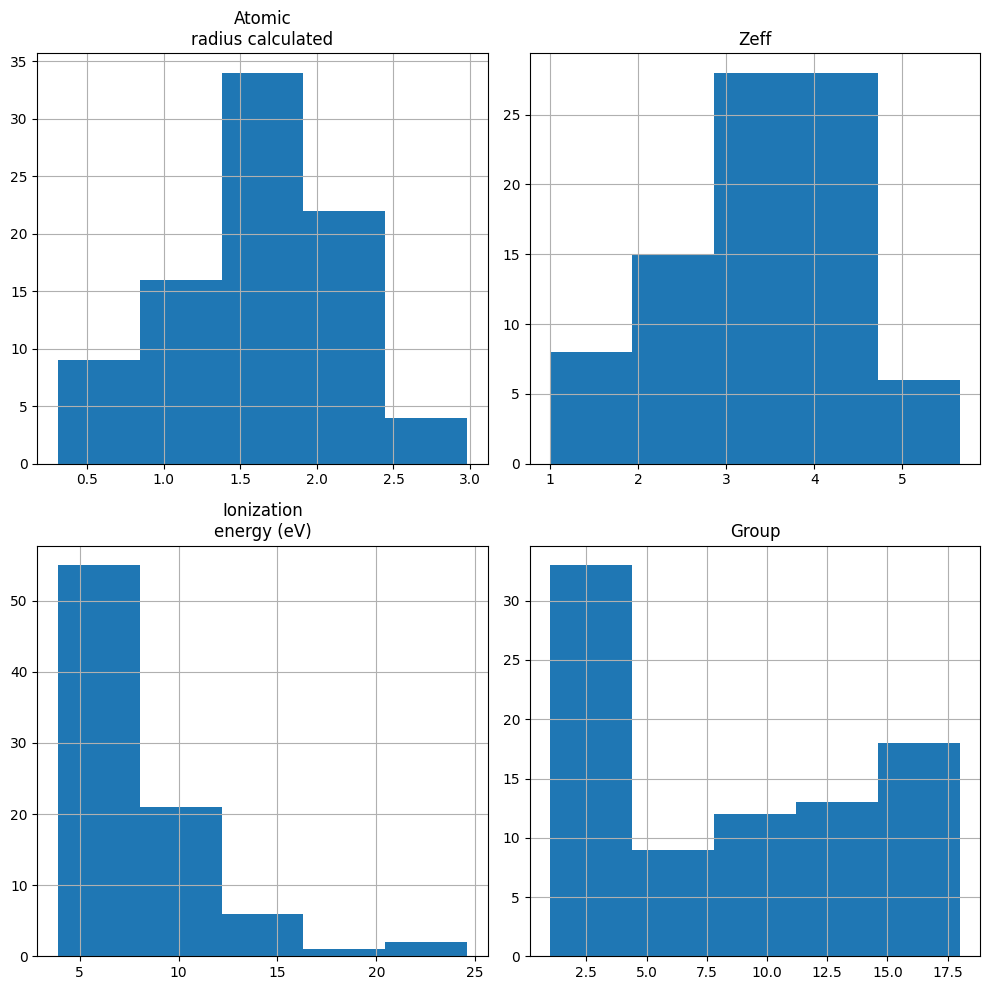

In [12]:
df1.hist(bins=5, figsize=(10,10))
plt.tight_layout()  
plt.show()

- ``Atomic Radius Calculated:``
    + Observation: Most elements have an atomic radius between 0.5 to 2.5 as shown by the histogram. There's a big group of elements with atomic radius around 1.0 to 1.5 also seen in this graph.
    + Interpretation: This distribution shows that a good part of the elements have atomic radius which is quite moderate, not too big or very small. The quantity of elements with atomic radius really big or very tiny is less compared to those in between these two extremes. Elements with intermediate atomic weights and sizes are seen a lot more than heavy and light ones, this happens often.

- ``Zeff:``
    + Observation: The histogram representing Zeff displays a distribution that is mostly concentrated between the values of 2.0 and 4.75, with the highest frequency occurring around the range of 3. to 4.75.
    + Interpretation: The distribution of elements shows that a significant number of elements experience a moderate effective nuclear charge. This indicates that a significant number of electrons in these elements experience a net positive charge in the 2.0 to 4.75 range, reflecting a balance between nuclear attraction and electron shielding.

- ``Ionization Energy (eV):``
    + Observation: The histogram of ionization energy shows a big peak between the value of 2.5 to 5.5, meaning many elements in the data set have a high attraction between the electron and the nucleus.
    + Interpretation: The arrangement of elements shows that many parts in the dataset have an average ionization energy. This range suggests these parts experience a significant but not excessive attraction between electron and nucleus. The elements possibly involve those from middle part of periodic table, like s-block and p-block elements except for very low (for instance alkali metals) or extremely high (such as noble gases) ionization energies. The focus here indicates similarities in their atomic structure and reactivity.

- ``Group:``
    + Observation: The histogram representing the variable 'Group' has a bimodal distribution, characterized by two distinct peaks. The first peak is seen in the lower groups, namely groups 1 to 4, while the second peak is observed in groups 14 to 16.
    + Interpretation: This distribution illustrates the prevalence of certain elements in different groups. The lower groups are mostly composed of alkali and alkaline earth metals, while the upper groups consist of carbon, nitrogen, and oxygen group elements, which are more abundant and diverse in nature.

## Box Diagram

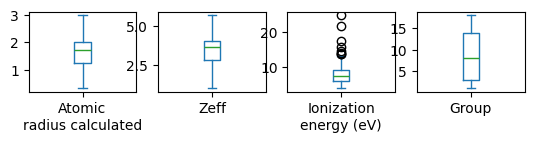

In [15]:
df1.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False)
plt.show()

- ``Atomic Radius Calculated:``
    + Median: Around 1.5.
    + Outliers: There are no outliers present in the data, and the values are closely clustered around the median, indicating a stable range for the majority of items.
- ``Zeff:``
    + Median: Around 2.5.
    + IQR: The box spans from around 2.5 to 4.0, suggesting that the inter quartile range of atomic radius falls within this interval.This indicates that the middle 50% of elements have Zeff values within this range
    + Outliers: There are no outliers present in the data, and the values are closely clustered around the median, indicating a stable range for the majority of items.
- ``Ionization energy (eV):``
    + Median: Around 5.0 eV.
    + IQR: The box is from about 5.0 eV to just under 10.0 eV, which means the middle 50% of elements have ionization energies within this range. It indicates that a good number of elements in dataset show moderately high ionization energies.
    + Outliers: There are quite a lot of outliers, which are elements that lie outside the IQR. This shows there are some with much lower or higher ionization energies compared to the central tendency. The probable reasons for these outliers could be elements like alkali metals (have very low ionization energies) and noble gases (have high ionization energies).
- ``Group:``
    + Median: Around 10.
    + IQR: From about 5 to 15, covering a spectrum of elements ranging from early transition metals to the pnictogens.
    + Outliers: No outliers are evident, suggesting that the data encompasses many groupings but does not reach the extreme ends of the periodic table.

> **<span style="font-size:1.5em;"></span> Interpretation:**
>- Atomic Radius: The atomic radius data shows a median value around 1.5, with an interquartile range (IQR) spanning from 1.0 to 2.0. This indicates that the middle 50% of the elements have atomic radius within this stable range. The absence of outliers suggests that the atomic radii of the elements in the dataset are consistently distributed without extreme variations.

>- Zeff:The Zeff data has a median value around 2.5, with an IQR from 2.5 to 4.0. This suggests that the majority of elements have Zeff values within this moderate range, indicating a consistent net positive charge experienced by the valence electrons across these elements. The lack of outliers points to a stable and uniform distribution of Zeff among the elements..

>- Ionization Energy:The ionization energy data shows a median around 5.0 eV, with an IQR extending from about 5.0 eV to just under 10.0 eV. This range indicates that the middle 50% of elements have moderately high ionization energies, reflecting a considerable attraction between the nucleus and the valence electrons. However, the presence of numerous outliers signifies a significant variability, with some elements having much lower (such as alkali metals) or much higher (such as noble gases) ionization energies compared to the central tendency.

>- Group Distribution: The group data has a median value around 10, with an IQR from about 5 to 15, covering a range from early transition metals to pnictogens. The lack of outliers suggests that the dataset includes elements from various groups but does not extend to the extreme ends of the periodic table (e.g., Group 1 or Group 18).

> **<span style="font-size:1.5em;"></span> Conclusions:**
>- The atomic radius and Zeff data suggest a stable and consistent distribution of these properties among the elements in the dataset, without significant deviations or extremes. This indicates that the majority of elements have comparable atomic sizes and effective nuclear charges.
>- The ionization energy data reveals a broader variability, with some elements exhibiting much lower or higher ionization energies. This reflects the diverse chemical reactivities and electron configurations among the elements, particularly highlighting the distinct properties of alkali metals and noble gases.

>- The group data distribution suggests that the dataset covers a wide range of elements, predominantly from the middle of the periodic table, but does not include the most extreme groups. This provides a balanced representation of elements across different chemical families without reaching the most reactive or inert extremes.


## Relationship between collumns
Analysing data in 4 collumns: 'Atomic radius calculated' 'Zeff', 'Ionization energy (eV)', 'Group' to find the relationship between them and answer the question.

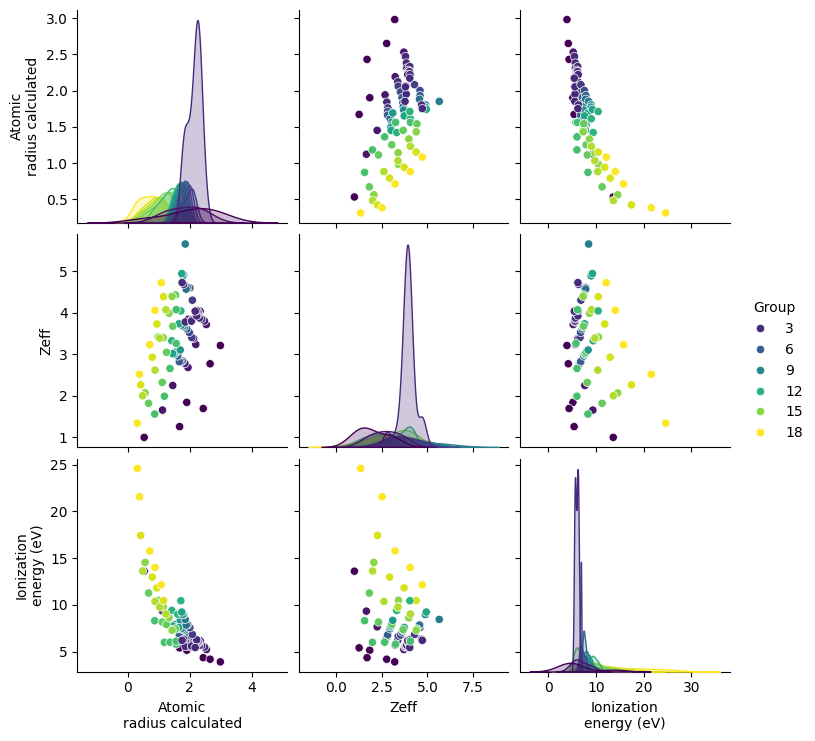

In [17]:
plt.rcdefaults()

df['Group'] = df['Group'].astype(int)
sns.pairplot(df, vars=['Atomic\nradius calculated', 'Zeff', 'Ionization\nenergy (eV)'], hue='Group', palette='viridis')
plt.show()

## Heatmaps

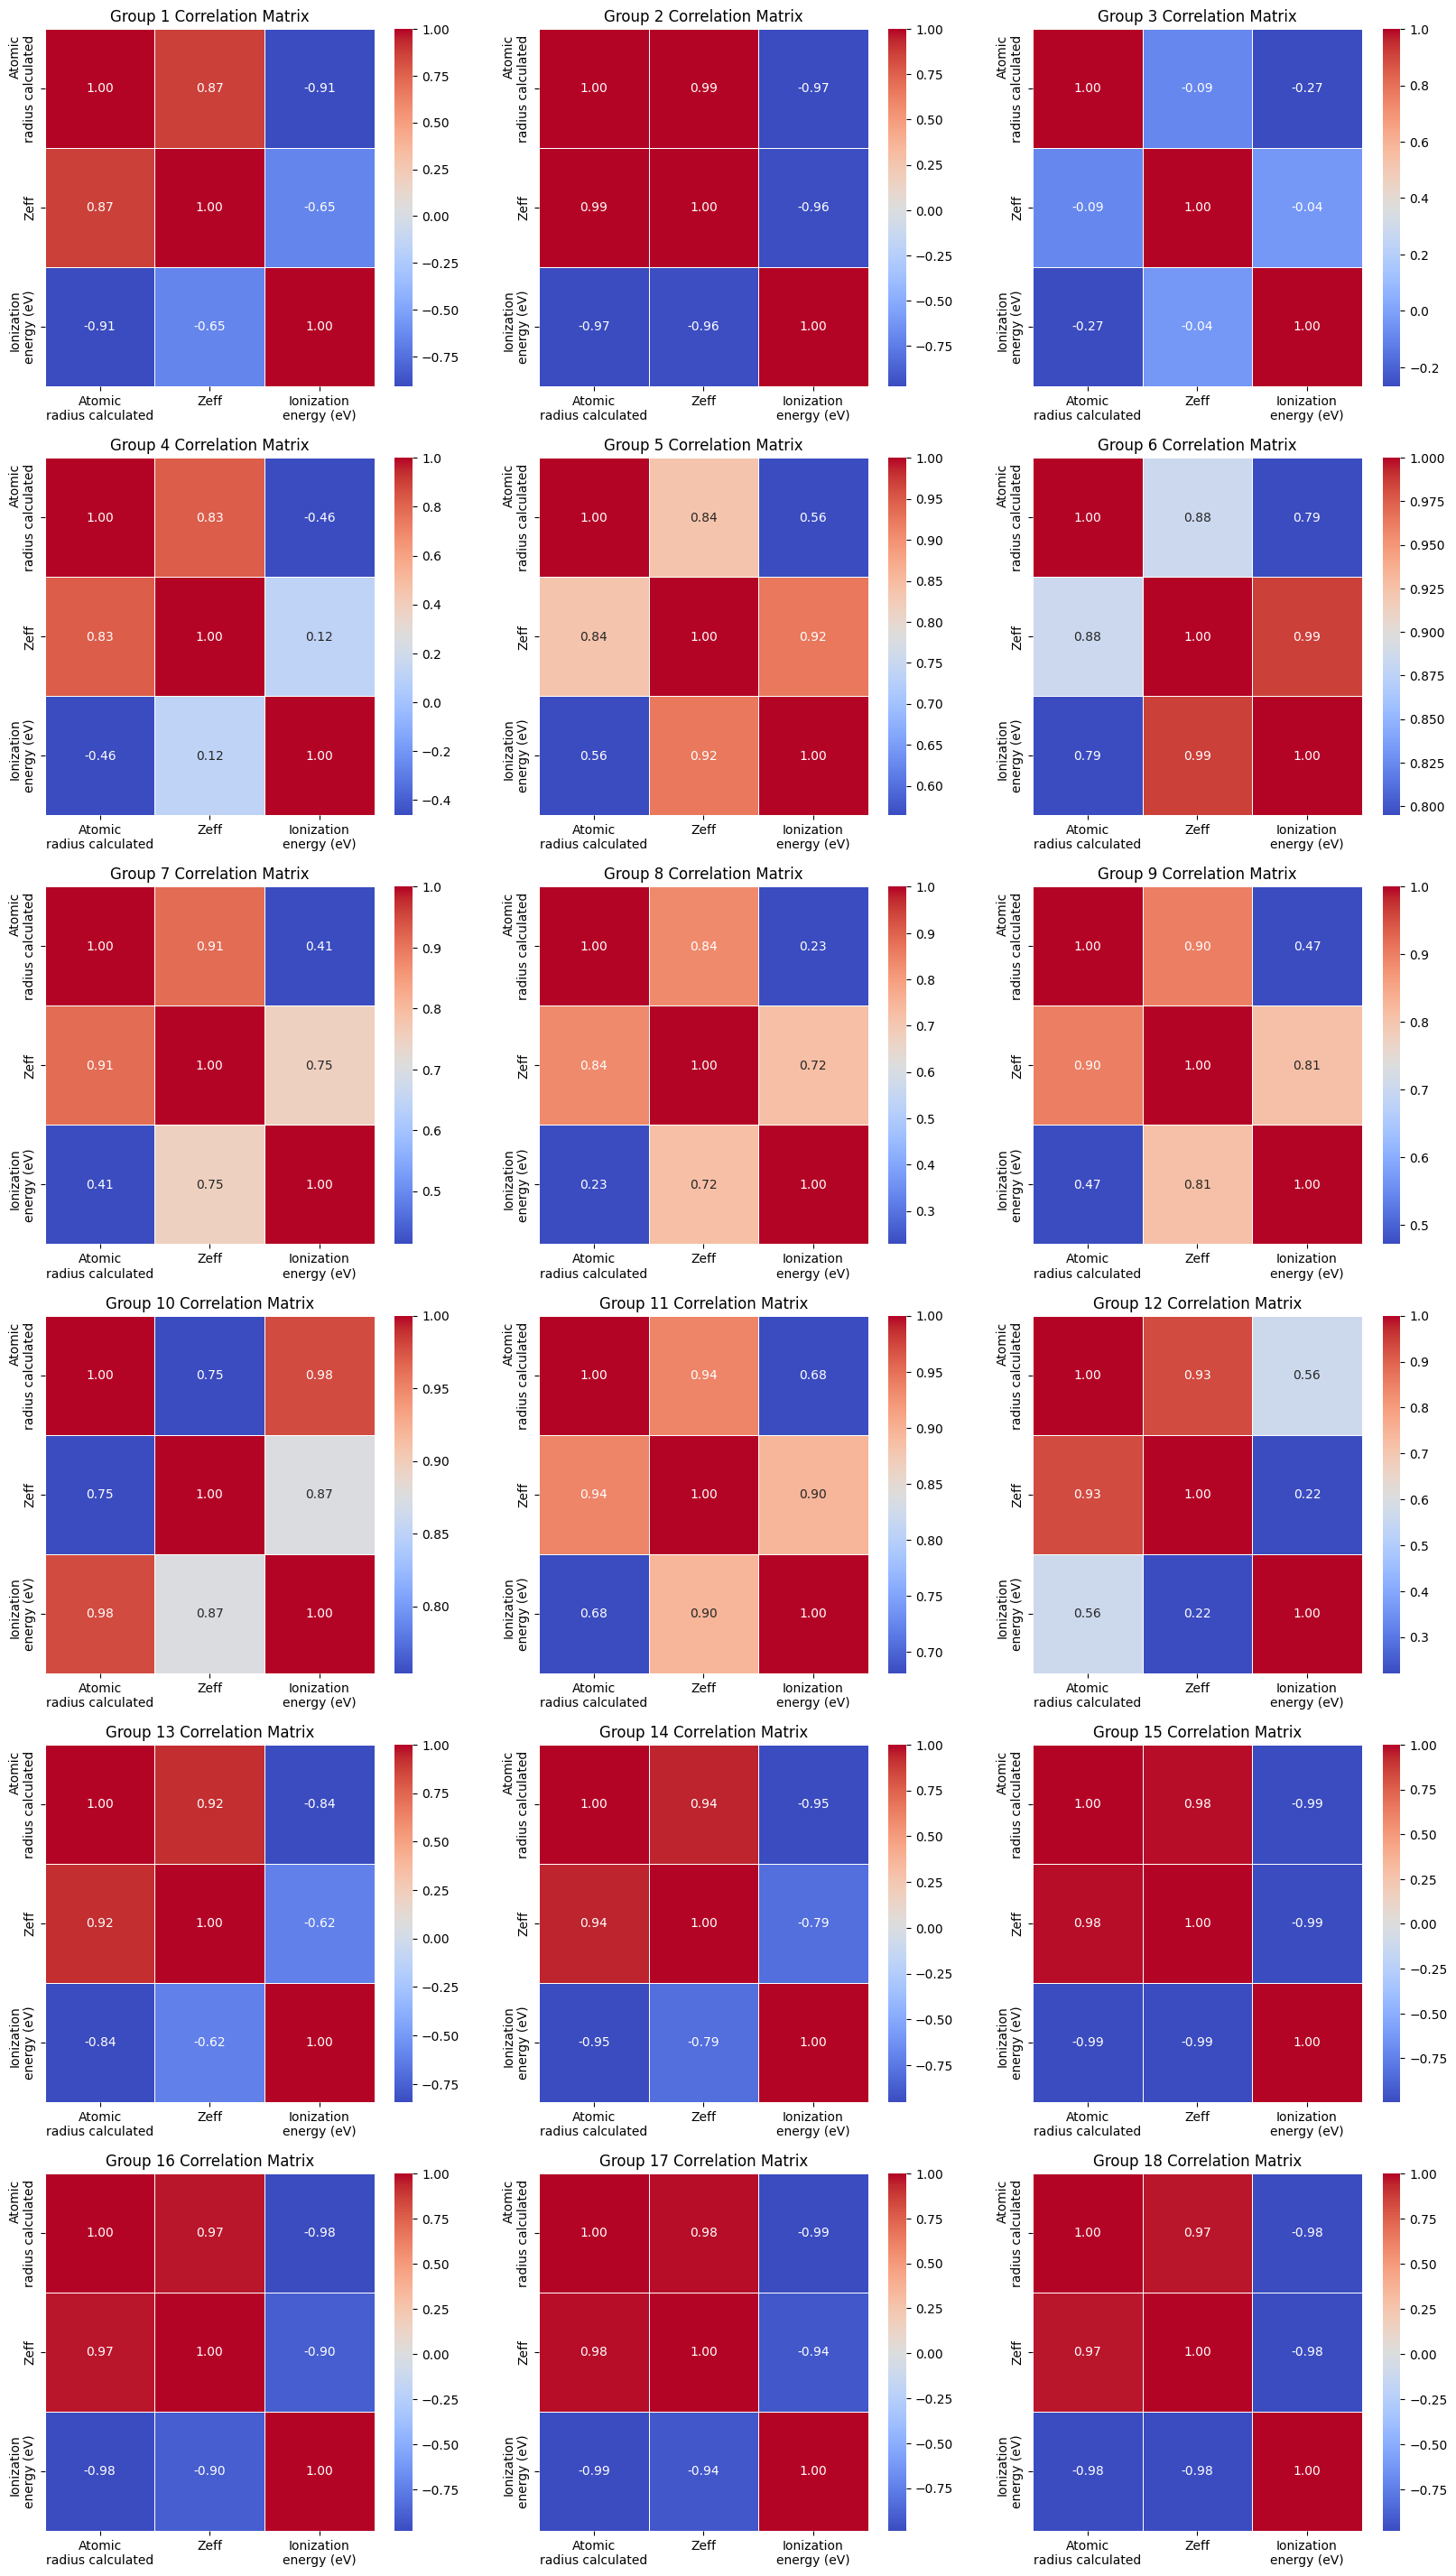

In [18]:
grouped = df.groupby('Group')

fig, axes = plt.subplots(nrows=int(grouped.ngroups/3), ncols=3, figsize=(20, 2 * grouped.ngroups))

axes = axes.flatten()

for (key, group), ax in zip(grouped, axes):
    corr_matrix = group[['Atomic\nradius calculated', 'Zeff', 'Ionization\nenergy (eV)']].corr()
    
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=ax)
    ax.set_title(f'Group {key} Correlation Matrix')

plt.show()

After looking at the group-specific heatmaps output, you can understand the connections between atomic size (atomic radius calculated), effective nuclear charge (zeff measured), and ionization energy (expressed in eV) for every group. A detailed analysis based on these correlations is presented below.

``General Observations:``
- Atomic Radius vs. Ionization Energy: Generally, an inverse correlation is expected. This means that within most groups, as the atomic radius increases, the ionization energy tends to decrease.
- Atomic Radius vs. Zeff: The correlation might be weaker or inconsistent within groups due to the balancing effect of shielding as you move down a group.
- Zeff vs. Ionization Energy: A positive correlation is expected, where higher Zeff values correlate with higher ionization energies, reflecting the stronger attraction between the nucleus and valence electrons.

``Group-Specific Trends:`` Different groups might show variations in the strength of these correlations due to their unique electronic configurations and positions in the periodic table.

Groups 1 and 2 (Alkali and Alkaline Earth Metals):

>- Atomic Radius vs. Ionization Energy: Strong negative correlation.
>- Interpretation: As expected, larger atoms (further down the group) have lower ionization energies because the outermost electron is further from the nucleus and less tightly bound.

>- Atomic Radius vs. Zeff: Weaker or inconsistent correlation.
>- Interpretation: Zeff increases slightly down the group, but not significantly enough to show a strong trend.

>- Zeff vs. Ionization Energy: Positive correlation.
>- Interpretation: Higher effective nuclear charge corresponds to higher ionization energies within these groups.

Groups 13-15 (p-block elements):

>- Atomic Radius vs. Ionization Energy: Moderate to strong negative correlation.
>- Interpretation: As expected, larger atoms (further down the group) have lower ionization energies because the outermost electron is further from the nucleus and less tightly bound.

>- Atomic Radius vs. Zeff: Moderate correlation.
>- Interpretation: As you move down these groups, Zeff increases due to added protons, although inner electron shielding also increases.

>- Zeff vs. Ionization Energy: Strong positive correlation.
>- Interpretation: Higher Zeff generally leads to higher ionization energies, as electrons are more tightly bound.

Groups 16-18 (Chalcogens, Halogens, Noble Gases):
>- Atomic Radius vs. Ionization Energy: Strong negative correlation, especially noticeable in halogens and noble gases.
>- Interpretation: Larger atomic radii correspond to significantly lower ionization energies. Noble gases, in particular, exhibit very high ionization energies for small atomic radius.

>- Atomic Radius vs. Zeff: Moderate to strong correlation.
>- Interpretation: Zeff increases down the group but is also affected by increased shielding.

>- Zeff vs. Ionization Energy: Very strong positive correlation.
>- Interpretation: Higher Zeff correlates with higher ionization energies, particularly pronounced in these groups due to their electronic configurations.


``Conclusion:``
These are the conclusion that was formed from analyzing the dataset:
- The heatmaps have shown us periodic patterns in these relationships. For instance, we can see the expected connection between atomic radius and ionization energy as it becomes smaller across different groups on one side and bigger on other sides. Likewise for Zeff with increasing Zeff values related to higher ionization energy results in a diagonal trend that matches expectations.
- Elements from one group display similar patterns of correlation, which mirrors their common chemical qualities. For instance, alkali metals demonstrate a strong opposite relationship between atomic radius and ionization energy; on the other hand, noble gases exhibit a powerful positive correlation between Zeff and ionization energy.
- Although we see general trends, certain groups can have special patterns because of their precise electronic arrangements. For example, transition metals might show different trends due to d-electron shielding effects.
- The data displays a noticeable range in ionization energy, with some elements that have exceptional electronic arrangements like alkali metals and noble gases appearing as outliers.
